# JobSeekerAgency: an Agentic Workflow to make the whole process of finding your next dream job effortless
* OpenAI models here: https://platform.openai.com/docs/models 

In [1]:
%cd ../.
import sys
sys.path.append('../keys'); # sys.path.append('./.')

/Users/giorgiotamo/Desktop/GT/Programming/Lavoro/GitHub/JobSeekerAgency


In [2]:
%load_ext autoreload
%autoreload 2

import os
import json
import pandas as pd
import numpy as np
import subprocess as sub
from copy import deepcopy
from datetime import datetime
import smtplib
from email.message import EmailMessage

## langchain:
from langchain_core.messages import ToolMessage, BaseMessage, AIMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver, InMemorySaver
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from langchain.tools import tool

## LLMs from providers:
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI

## Langgraph:
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages

## Typing
from pydantic import BaseModel, Field
from typing import List,Sequence,TypedDict,Annotated,Literal

## Custom scripts:
import Constants as C
from graph.nodes import *
from graph.edges import *
from graph.state import *
from python.tools import *
from python.functions import *

## Visualize the graph:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

In [3]:
os.environ['OPENAI_API_KEY'] = C.OPENAI_API_KEY
os.environ['SERPAPI_API_KEY'] = C.SERPAPI_API_KEY # make sure it spelled as: SERPAPI_API_KEY
os.environ['ANTHROPIC_API_KEY'] = C.ANTHROPIC_API_KEY
os.environ['GMAIL_USER'] = C.GMAIL_USER
os.environ['GMAIL_APP_PASS'] = C.GMAIL_APP_PASS

# MAIN

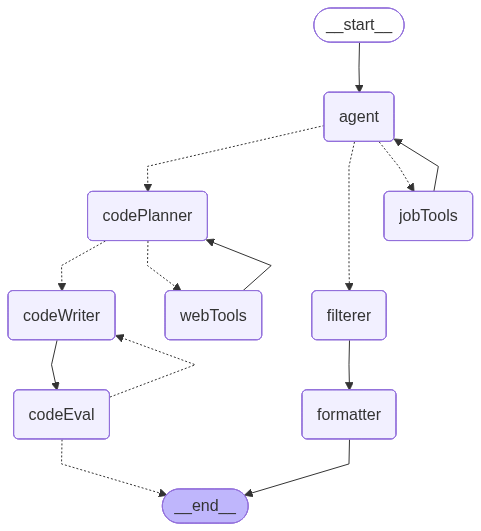

In [4]:
# Defining tool nodes (from graph.nodes)
job_tool_node = ToolNode(job_tools)
web_tool_node = ToolNode(web_tools) 

workflow  = StateGraph(ChatMessages) # from graph.state

## adding nodes
workflow.add_node('agent',call_agent)
workflow.add_node('jobTools',job_tool_node)
workflow.add_node('filterer',joblist_filtering)
workflow.add_node('formatter',joblist_formatting)
workflow.add_node('codeWriter',code_writing)
workflow.add_node('codePlanner',code_planning)
workflow.add_node('webTools',web_tool_node)
workflow.add_node('codeEval',code_eval)

## adding edges and routing
workflow.add_edge(START,'agent')
workflow.add_conditional_edges('agent',Router1) # setting router function for the agent
workflow.add_edge('jobTools','agent') # you want to link tools to agent because agent is responsible for giving an answer to human
workflow.add_edge('filterer','formatter')
workflow.add_conditional_edges('codePlanner',Router2)
workflow.add_edge('webTools','codePlanner')
workflow.add_edge('codeWriter','codeEval')
workflow.add_conditional_edges('codeEval',Is_code_ok_YN) # setting router function for the agent

checkpointer = MemorySaver() # set memory
graph = workflow.compile(checkpointer=checkpointer) # 
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API,max_retries=5, retry_delay=2.0)))
# graph.get_graph().print_ascii()

In [5]:
# %%time # remove the cell magic for await .ainvoke!!
# company2careerpage = {
#     'CSL':'https://csl.wd1.myworkdayjobs.com/en-EN/CSL_External?locationCountry=187134fccb084a0ea9b4b95f23890dbe',
#     'NOVARTIS':'https://www.novartis.com/careers/career-search?search_api_fulltext=data&country%5B0%5D=LOC_CH&field_job_posted_date=2&op=Submit',
#     'VISIUM':'https://www.visium.com/join-us#open-positions',
#     #'LENOVO':'https://jobs.lenovo.com/en_US/careers/SearchJobs/?13036=%5B12016783%5D&13036_format=6621&listFilterMode=1&jobRecordsPerPage=10&',
#     'AWS':'https://www.amazon.jobs/content/en/locations/switzerland/zurich?category%5B%5D=Solutions+Architect',
#     'ROCHE':'https://roche.wd3.myworkdayjobs.com/en-US/roche-ext?q=machine%20learning&locations=3543744a0e67010b8e1b9bd75b7637a4',
#     #'YPSOMED':'https://careers.ypsomed.com/ypsomed/en/professional/',
#     'J&J':'https://www.careers.jnj.com/en/jobs/?search=&team=Data+Analytics+%26+Computational+Sciences&country=Switzerland&pagesize=20#results',
#     #'INCYTE':'https://careers.incyte.com/jobs?searchType=location&page=1&stretch=10&stretchUnit=MILES&locations=Morges,Vaud,Switzerland%7C,,Switzerland&sortBy=relevance',
#     'ISO':'https://www.isomorphiclabs.com/job-openings',
#     'MONTEROSA':'https://www.monterosatx.com/careers/',
#     #'BASILEA':'https://basilea.jobs.personio.de/',
#     'IDORSIA':'https://careers.idorsia.com/search/?createNewAlert=false&q=&locationsearch=switzerland',
# }
## Get all company career pages from JSON file
with open('./data/company2careerpage.json', 'r') as f:
    company2careerpage = json.load(f)

# 'Can you tell me who is the coolest guy in the universe?' #
# for select in company2careerpage.keys():
select     = 'MERCK'
print('>> looking for jobs for',select)
question   = f'can you simply get the current jobs associated with this company {select}?' ## 'can you tell me who is the coolest guy in the universe?'
input_data = {"messages": HumanMessage(content=question),'company':select,'company2careerpage':company2careerpage,'codeiter': 0}
messages   = await graph.ainvoke(input=input_data, config={"configurable": {"thread_id": 1}})
print('>> done, if new code was written, please add to tools.py and add to tool list')
# tmp_df = update_joblist(messages)

>> looking for jobs for MERCK
>> 0. First pass >>
>> 0.1 Router1
> 0.2 calling tool
>> 0. First pass >>
>> 0.1 Router1
>> 1.a filtering relevant jobs >>
>> 2.a Formatting job list >>
>> done, if new code was written, please add to tools.py and add to tool list


In [7]:
# for m in messages["messages"]:
#     m.pretty_print()

#### Looking for all companies (done in script)

In [ ]:
for select in company2careerpage.keys():
    
    ## 1. Building the graph
    ## --------------------------
    # Defining tool nodes (from graph.nodes)
    job_tool_node = ToolNode(job_tools)
    web_tool_node = ToolNode(web_tools) 
    
    workflow  = StateGraph(ChatMessages) # from graph.state
    
    ## adding nodes
    workflow.add_node('agent',call_agent)
    workflow.add_node('jobTools',job_tool_node)
    workflow.add_node('filterer',joblist_filtering)
    workflow.add_node('formatter',joblist_formatting)
    workflow.add_node('codeWriter',code_writing)
    workflow.add_node('codePlanner',code_planning)
    workflow.add_node('webTools',web_tool_node)
    workflow.add_node('codeEval',code_eval)
    
    ## adding edges and routing
    workflow.add_edge(START,'agent')
    workflow.add_conditional_edges('agent',Router1) # setting router function for the agent
    workflow.add_edge('jobTools','agent') # you want to link tools to agent because agent is responsible for giving an answer to human
    workflow.add_edge('filterer','formatter')
    workflow.add_conditional_edges('codePlanner',Router2)
    workflow.add_edge('webTools','codePlanner')
    workflow.add_edge('codeWriter','codeEval')
    workflow.add_conditional_edges('codeEval',Is_code_ok_YN) # setting router function for the agent
    
    checkpointer = MemorySaver() # set memory
    graph = workflow.compile(checkpointer=checkpointer) # 
    
    ## 1. running the graph
    ## --------------------------
    print('\n>> looking for jobs for',select)
    print('>> ------------------------------------')
    question   = f'can you simply get the current jobs associated with this company {select}?' ## 'can you tell me who is the coolest guy in the universe?'
    input_data = {"messages": HumanMessage(content=question),'company':select,'company2careerpage':company2careerpage,'codeiter': 0}
    messages   = await graph.ainvoke(input=input_data, config={"configurable": {"thread_id": 1}})
    print('>> done, if new code was written, please add to tools.py and add to tool list')
    update_joblist(messages)


>> looking for jobs for CSL
>> ------------------------------------
>> 0. First pass >>


CancelledError: 

In [ ]:
# find jobs matching todays date
todate = datetime.today().strftime('%Y-%m-%d')
df = pd.read_csv('./output/updated_joblist.csv')
df_td = df.sort_values('date',ascending=False)
df_td = df_td[df_td['date']==todate]

# format table as text:
df_td_text = df_td.to_string(index=False)
print(df_td_text)

                                                              name                                                                                                                                                                                                             url company       date
Sr Director, R&D Data Science & Digital Health – Neurodegeneration                                                                                                      https://www.careers.jnj.com/en/jobs/r-051922/sr-director-rd-data-science-digital-health-neurodegeneration/     j&j 2026-01-12
                                          Data Sciences Internship                                            https://roche.wd3.myworkdayjobs.com/en-US/roche-ext/job/Basel/Data-Sciences-Internship_202512-132554-1?q=machine+learning&locations=3543744a0e67010b8e1b9bd75b7637a4   roche 2026-01-12
            Senior Product Manager (Computational Biology), London                                                    

In [ ]:


# Generate HTML and preview
html_table = df_to_gmail_html(df_td)

from IPython.display import HTML, display
display(HTML(html_table))

Job Title,Company,Date
"Sr Director, R&D Data Science & Digital Health – Neurodegeneration",J&J,2026-01-12
Data Sciences Internship,ROCHE,2026-01-12
"Senior Product Manager (Computational Biology), London",ISO,2026-01-12
"Manager, Global Reporting & Business Intelligence",CSL,2026-01-12


In [ ]:
# for m in messages["messages"]:
#     m.pretty_print()

In [ ]:
import os


html_table = df_to_gmail_html(df_td)



## single agent writing

In [ ]:
# capture the joblist
joblist = deepcopy(messages['messages'][-2].content)

In [ ]:
state_ = ChatMessages()
state_['joblist'] = joblist
state_['messages'] = []

In [ ]:
# def joblist_filtering(state):
#     """
#     Takes the list of job and filter
#     """

#     print(f'>> 1.a filtering relevant jobs >>')
    
#     messages = state['messages']

#     system_message = SystemMessage(content="""You are a helpful assistant with the following tasks:
#     given a list of jobs including the job name and url, ONLY keep jobs related to:
#     -machine learning / AI
#     -cheminformatics
#     -Computational assisted drug discovery (CADD)
#     -Computational Chemistry
#     -Data Science
#     """)

#     question   = f"""can you extract the relevant jobs from this job list: '{state['joblist']}'?""" 
#     human_message = HumanMessage(content=question)
#     # 3. ask model
#     model = ChatOpenAI(model=['gpt-4o-mini','gpt-5','gpt-5.2-2025-12-11'][-1],temperature=0)
#     messages = [system_message]+ [human_message] + state["messages"]
#     # print(messages)
#     result = model.invoke(messages)
#     print(result.content)
#     response = { "messages": [result], "question":result.content }
    
#     # print(response['question'])
    
#     return response

In [ ]:
res = joblist_filtering(state_)

>> 1.a filtering relevant jobs >>
- Associate Director, Data Scientist (Human Genetics) — https://www.novartis.com/careers/career-search/job/details/req-10053562-associate-director-data-scientist-human-genetics — Dec 02, 2025  
- HTA Evidence Synthesis Statistician — https://www.novartis.com/careers/career-search/job/details/req-10047718-hta-evidence-synthesis-statistician — Sep 15, 2025


In [ ]:
print(res['messages'][-1].content)

- Associate Director, Data Scientist (Human Genetics) — https://www.novartis.com/careers/career-search/job/details/req-10053562-associate-director-data-scientist-human-genetics — Dec 02, 2025
- HTA Evidence Synthesis Statistician — https://www.novartis.com/careers/career-search/job/details/req-10047718-hta-evidence-synthesis-statistician — Sep 15, 2025


## Interactive code writing (2brm)

In [ ]:
# !pip install nest-asyncio
import nest_asyncio
nest_asyncio.apply()

In [ ]:
%%time
company2careerpage = {
    'CSL':'https://csl.wd1.myworkdayjobs.com/en-EN/CSL_External?locationCountry=187134fccb084a0ea9b4b95f23890dbe',
    'NOVARTIS':'https://www.novartis.com/careers/career-search?search_api_fulltext=data&country%5B0%5D=LOC_CH&field_job_posted_date=2&op=Submit',
    'VISIUM':'https://www.visium.com/join-us#open-positions',
    'LENOVO':'https://jobs.lenovo.com/en_US/careers/SearchJobs/?13036=%5B12016783%5D&13036_format=6621&listFilterMode=1&jobRecordsPerPage=10&',
    'AWS':'https://www.amazon.jobs/content/en/locations/switzerland/zurich?category%5B%5D=Solutions+Architect',
    'ROCHE':'https://roche.wd3.myworkdayjobs.com/en-US/roche-ext?q=machine%20learning&locations=3543744a0e67010b8e1b9bd75b7637a4',
    'YPSOMED':'https://careers.ypsomed.com/ypsomed/en/professional/',
    'J&J':'https://www.careers.jnj.com/en/jobs/?search=&team=Data+Analytics+%26+Computational+Sciences&country=Switzerland&pagesize=20#results',
    'INCYTE':'https://careers.incyte.com/jobs?searchType=location&page=1&stretch=10&stretchUnit=MILES&locations=Morges,Vaud,Switzerland%7C,,Switzerland&sortBy=relevance',
}
url      = company2careerpage['ROCHE']
jobs = get_ROCHE_jobs(url)

CPU times: user 46.1 ms, sys: 12.6 ms, total: 58.7 ms
Wall time: 8.84 s


In [ ]:
%%time
output = """- Scientist - AI & ML for Protein and Antibody Engineering - https://roche.wd3.myworkdayjobs.com/en-US/roche-ext/job/Basel/Scientist---AI---ML-for-Protein-and-Antibody-Engineering_202601-100101-1?q=machine+learning&locations=3543744a0e67010b8e1b9bd75b7637a4  
- Chief of Staff, Computational Center of Excellence (CoE) - https://roche.wd3.myworkdayjobs.com/en-US/roche-ext/job/San-Francisco/Chief-of-Staff--Computational-Center-of-Excellence--CoE-_202504-109804-2?q=machine+learning&locations=3543744a0e67010b8e1b9bd75b7637a4  
- Scientist / Senior Scientist in Cheminformatics - https://roche.wd3.myworkdayjobs.com/en-US/roche-ext/job/Basel/Scientist---Senior-Scientist-in-Cheminformatics_202512-132127-1?q=machine+learning&locations=3543744a0e67010b8e1b9bd75b7637a4  
- Senior / Principal Cheminformatics Scientist - https://roche.wd3.myworkdayjobs.com/en-US/roche-ext/job/Basel/Senior---Principal-Cheminformatics-Scientist_202512-132129-2?q=machine+learning&locations=3543744a0e67010b8e1b9bd75b7637a4  
- Computational Statistician - Oncology - https://roche.wd3.myworkdayjobs.com/en-US/roche-ext/job/Basel/Computational-Statistician---Oncology_202511-129306-2?q=machine+learning&locations=3543744a0e67010b8e1b9bd75b7637a4  
- Post Doctorate Scientist - https://roche.wd3.myworkdayjobs.com/en-US/roche-ext/job/Basel/Post-Doc-Wissenschaftler--m-w-d-_202510-127763?q=machine+learning&locations=3543744a0e67010b8e1b9bd75b7637a4  
- Principal DevOps Engineer - ML/AI Algorithms - https://roche.wd3.myworkdayjobs.com/en-US/roche-ext/job/Santa-Clara/Principal-DevOps-Engineer---ML-AI-Algorithms_202510-125713-1?q=machine+learning&locations=3543744a0e67010b8e1b9bd75b7637a4  
- Post Doctorate Scientist Single Cell Technologies - https://roche.wd3.myworkdayjobs.com/en-US/roche-ext/job/Basel/Post-Doctorate-Scientist-Single-Cell-Technologies_202510-127668-1?q=machine+learning&locations=3543744a0e67010b8e1b9bd75b7637a4  
- PhD Student Single Cell Technologies - https://roche.wd3.myworkdayjobs.com/en-US/roche-ext/job/Basel/PhD-Student-Single-Cell-Technologies_202510-127669-1?q=machine+learning&locations=3543744a0e67010b8e1b9bd75b7637a4  
- Capability Tech Lead - Solutions Engineering - https://roche.wd3.myworkdayjobs.com/en-US/roche-ext/job/Basel/Capability-Tech-Lead---Solutions-Engineering_202508-121830-2?q=machine+learning&locations=3543744a0e67010b8e1b9bd75b7637a4  
- Senior Director, Software Engineering - https://roche.wd3.myworkdayjobs.com/en-US/roche-ext/job/Basel/Senior-Director--Software-Engineering_202508-121675-2?q=machine+learning&locations=3543744a0e67010b8e1b9bd75b7637a4"""

code = """
    messages = state['messages']
    state['joblist'] = messages[-1].content

    system_message = SystemMessage(content="You are a helpful assistant with the following tasks:
    given a list of jobs including the job name and url, ONLY keep jobs related to:
    -machine learning / AI
    -cheminformatics
    -Computational assisted drug discovery (CADD)
    -Computational Chemistry
    -Data Science
    ")

    question   = f"can you extract the relevant jobs from this job list: '{state['joblist']}'?" 
    human_message = HumanMessage(content=question)
    # 3. ask model
    model = ChatOpenAI(model=['gpt-4o-mini','gpt-5','gpt-5.2-2025-12-11'][-1],temperature=0)
    messages = [system_message]+ [human_message] + state["messages"]
    # print(messages)
    result = await model.ainvoke(messages)
    # print(result)
    response = { "messages": [result], "joblist":result.content }
        
    return response
"""

system_message = SystemMessage(content="""You are an expert python programmer that write very consice code.""") # 
question = f"""I used the following python code '{code}' to only extract jobs related to machine learning / AI,cheminformatics,Computational assisted drug discovery (CADD),Computational Chemistry, Data Science. 
However sometimes, the filtering does not work and get all the jobs including unrelated jobs just like the output: {output}, can you tell me how to correct my code?""" 
human_message = HumanMessage(content=question)
# 3. ask model
model = ChatAnthropic(model="claude-sonnet-4-5",temperature=0)
messages = [system_message]+ [human_message]
result= model.invoke(messages)

CPU times: user 26.5 ms, sys: 2.59 ms, total: 29.1 ms
Wall time: 9.75 s


In [ ]:
print(result.content)

The issue is that you're including the entire conversation history (`state["messages"]`) which may contain the original unfiltered job list, confusing the model. Here's the corrected code:

```python
messages = state['messages']
state['joblist'] = messages[-1].content

system_message = SystemMessage(content="""You are a strict job filter. ONLY return jobs that are directly related to:
- Machine Learning / AI
- Cheminformatics
- Computational Assisted Drug Discovery (CADD)
- Computational Chemistry
- Data Science

EXCLUDE jobs like: DevOps, Software Engineering, Tech Lead, general Post-Doc positions, or any role not directly involving the above fields.
Return ONLY the filtered job list in the same format.""")

question = f"Filter and return ONLY relevant jobs from:\n{state['joblist']}"
human_message = HumanMessage(content=question)

model = ChatOpenAI(model='gpt-4o-mini', temperature=0)
messages = [system_message, human_message]  # Don't include state["messages"]

result = await model.a

In [ ]:
# %%time
# system_message = SystemMessage(content="""You are an expert python programmer that write very consice code. You only ouptut python code without additional comments.""") # 
# question = """Can you write a python script using Beautiful soup that:
# - takes as input a career website url
# - extracts the most essential information from this website 
# - returns a summarized html version which can be then be used to build a strategy on how to most effectively extract jobs and urls from that website""" 
# human_message = HumanMessage(content=question)
# # 3. ask model
# model = ChatAnthropic(model="claude-sonnet-4-5",temperature=0)
# messages = [system_message]+ [human_message]
# result= model.invoke(messages)

In [ ]:
# print(result.content)